# Clasificación de pérdidas de potencia de paneles solares debido a suciedad

Integrantes:
- Nicolle Contreras Alejo
- Samuel Andrey Gelvez Osorio
- Nicolás Merchán Rodríguez

## Extraer etiquetas de las imágenes

In [52]:
import os
import numpy as np
import pandas as pd

# Se extraen las etiquetas de las imágenes
images = os.listdir("imagenes/")

print(images[0:10])
print(len(images))

['solar_Fri_Jun_16_10__0__11_2017_L_0.906153208302_I_0.321592156863.jpg', 'solar_Fri_Jun_16_10__0__16_2017_L_0.903081697073_I_0.293192156863.jpg', 'solar_Fri_Jun_16_10__0__1_2017_L_0.916698044034_I_0.39577254902.jpg', 'solar_Fri_Jun_16_10__0__21_2017_L_0.903081697073_I_0.293192156863.jpg', 'solar_Fri_Jun_16_10__0__26_2017_L_0.896087391118_I_0.27462745098.jpg', 'solar_Fri_Jun_16_10__0__31_2017_L_0.896087391118_I_0.27462745098.jpg', 'solar_Fri_Jun_16_10__0__36_2017_L_0.894974574172_I_0.269141176471.jpg', 'solar_Fri_Jun_16_10__0__41_2017_L_0.894974574172_I_0.269141176471.jpg', 'solar_Fri_Jun_16_10__0__46_2017_L_0.890988502987_I_0.261278431373.jpg', 'solar_Fri_Jun_16_10__0__51_2017_L_0.890988502987_I_0.261278431373.jpg']
45754


## A partir de las etiquetas, donde se encuentran las pérdidas de potencia del panel registradas para esa imagen, se extraen la clase de cada imagen. Se consideraron 5 clases:

- **Clase 0:** Panel con pérdidas de potencia entre un 0% y 20%
- **Clase 1:** Panel con pérdidas de potencia entre un 20% y 40%
- **Clase 2:** Panel con pérdidas de potencia entre un 40% y 60%
- **Clase 3:** Panel con pérdidas de potencia entre un 60% y 80%
- **Clase 4:** Panel con pérdidas de potencia entre un 80% y 100%

In [53]:
import re

clases = ["0-20","20-40","40-60","60-80","80-100"]
clase = []

for img in images:
    lista = re.sub(".jpg","", img).split(sep='_')

    losses = float(lista[11])
    
    if losses > 0.8:
        clase.append(4)
    elif losses > 0.6:
        clase.append(3)
    elif losses > 0.4: 
        clase.append(2)
    elif losses > 0.2: 
        clase.append(1)
    else:
        clase.append(0)
    #print(losses, clase[-1])

for i, c in enumerate(clases):
    print(f'Clase: {c}. Cantidad de imágenes: {clase.count(i)}')

Clase: 0-20. Cantidad de imágenes: 27537
Clase: 20-40. Cantidad de imágenes: 4846
Clase: 40-60. Cantidad de imágenes: 3772
Clase: 60-80. Cantidad de imágenes: 6570
Clase: 80-100. Cantidad de imágenes: 3029


## Visualizar algunas imágenes del dataset con su respectiva clase

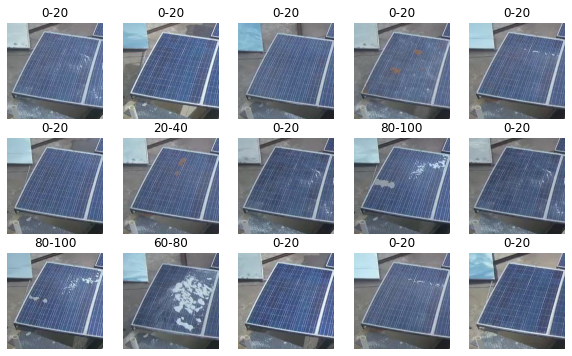

In [54]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(images)-1)
        img = io.imread("imagenes/" + images[ix])
        ax.imshow(img)
        #print(img.shape)
        ax.axis('off')
        ax.set_title(clases[clase[ix]])
plt.show()

## Dividir imagenes para train y test

Se utilizó el 80% de las imágenes para entrenar y el 20% para validar

In [55]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(images, clase, test_size=0.2, stratify=clase)

len(train_imgs), len(test_imgs)

(36603, 9151)

## Objeto dataset

In [56]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, trans, device):
        self.X = X
        self.y = y
        self.trans = trans
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        # cargar la imágen
        img = io.imread("imagenes/" + self.X[ix])
        # aplicar transformaciones
        if self.trans:
            img = self.trans(image=img)["image"]
        return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

## ResNet18 Model

In [57]:
import torchvision

class Model(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False, p=0):
        super().__init__()
        # descargamos resnet
        resnet = torchvision.models.resnet18(pretrained=pretrained)
        # nos quedamos con todas las capas menos la última
        self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
        if freeze:
            for param in self.resnet.parameters():
                param.requires_grad=False
        self.dropout = torch.nn.Dropout(p)
        # añadimos una nueva capa lineal para llevar a cabo la clasificación
        self.fc = torch.nn.Linear(512, n_outputs)

    def forward(self, x):
        x = self.resnet(x)        
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.resnet.parameters():
            param.requires_grad=True

# 1) Red entreanada con imagenes originales del dataset

# 3) Red entrenada con Data Augmentation y Dropout

## Crear set de entrenamiento y set de test

Cantidad de imágenes de entrenamiento:  36603 Cantidad de imágenes de test:  9151
Dimensión de entrada de las imágenes:  torch.Size([64, 3, 192, 192])


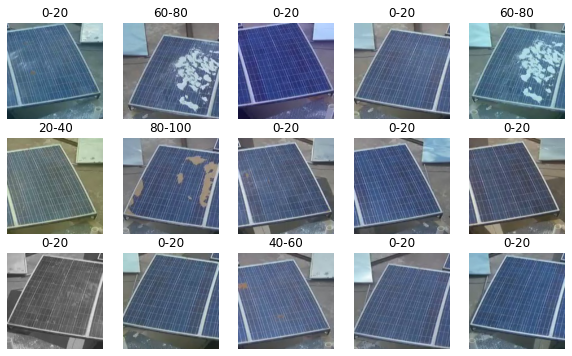

In [58]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans_train = Compose([
    RandomCrop(170,170),
    Resize(192, 192),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

trans_test = Compose([
    Resize(192, 192)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans_train, device), 
    'test': Dataset(test_imgs, test_labels, trans_test, device)
}

print("Cantidad de imágenes de entrenamiento: ", len(dataset['train']), "Cantidad de imágenes de test: ",len(dataset['test']))

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))

print("Dimensión de entrada de las imágenes: ", imgs.shape)

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(dataset['train'])-1)
        img, lab = dataset['train'][ix]
        ax.imshow(img.permute(1,2,0))
        ax.axis('off')
        ax.set_title(clases[lab])
plt.show()


In [59]:
model = Model(p = 0.25)
outputs = model(torch.randn(64, 3, 192, 192))
outputs.shape

torch.Size([64, 5])

In [60]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

    return {'epoch': list(range(1, len(train_loss)+1)), 'loss': train_loss, 'acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc}

In [61]:
model_Aug_Drop = Model(p = 0.2)
hist = fit(model_Aug_Drop, dataloader, epochs=6)

val_loss 0.72564 val_acc 0.76183: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]


Epoch 1/6 loss 0.82786 val_loss 0.72564 acc 0.72953 val_acc 0.76183


val_loss 1.07294 val_acc 0.69852: 100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


Epoch 2/6 loss 0.54284 val_loss 1.07294 acc 0.82456 val_acc 0.69852


val_loss 0.51168 val_acc 0.80451: 100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


Epoch 3/6 loss 0.45978 val_loss 0.51168 acc 0.86080 val_acc 0.80451


val_loss 0.45264 val_acc 0.86905: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


Epoch 4/6 loss 0.42641 val_loss 0.45264 acc 0.87453 val_acc 0.86905


val_loss 0.48495 val_acc 0.87961: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s]


Epoch 5/6 loss 0.40523 val_loss 0.48495 acc 0.87911 val_acc 0.87961


val_loss 0.46116 val_acc 0.87422: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s]

Epoch 6/6 loss 0.39094 val_loss 0.46116 acc 0.88200 val_acc 0.87422


### Evolución del entrenamiento

In [63]:
hist

{'epoch': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,


ValueError: All arrays must be of the same length

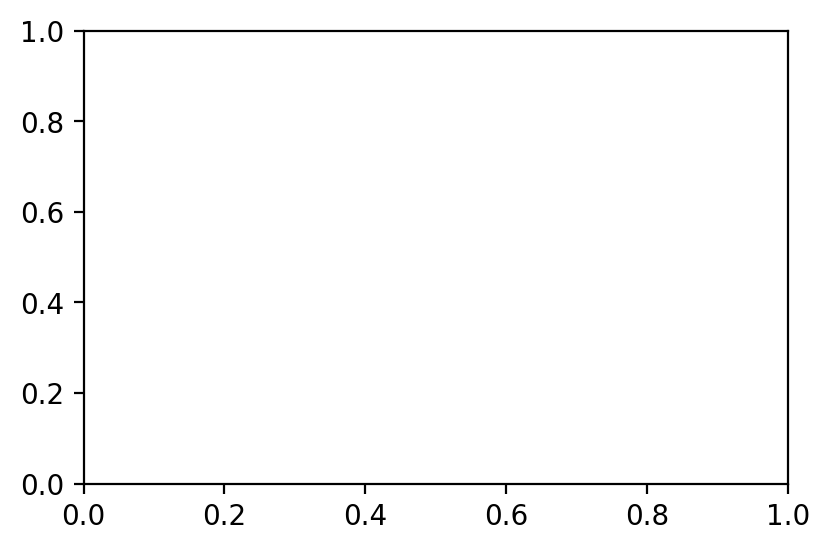

In [62]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

### Guardar modelo

In [64]:
torch.save(model_Aug_Drop, 'model_Aug_Drop.pt')

### Cargar modelo

In [65]:
model_Aug_Drop = torch.load('model_Aug_Drop.pt')

torch.Size([1, 3, 192, 192])

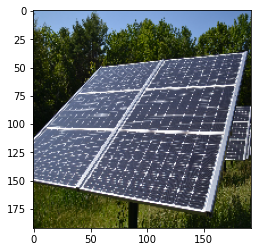

In [69]:
prueba = io.imread("prueba.jpg")
prueba = trans_test(image=prueba)["image"]

import matplotlib.pyplot as plt

plt.imshow(prueba)

prueba = torch.from_numpy(prueba / 255.).float().permute(2,0,1)

prueba = prueba.reshape(1,3,192,192)

prueba.shape

In [70]:
#prueba = prueba.to(device)

In [71]:
model.eval()
model(prueba)

tensor([[ 0.0188, -0.0256,  0.0151, -0.0265, -0.0324]],
       grad_fn=<AddmmBackward>)